This inference notebook is based on [motono0223's notebook](https://www.kaggle.com/code/motono0223/guie-clip-tensorflow-train-example) and his datasets with some improvements.


## Model
### for training:
- STEP1 Training **without** backbone model layers


backbone(CLIP VIT with [openai/clip-vit-large-patch14-336](https://huggingface.co/openai/clip-vit-large-patch14-336)) + Dropout + Dense(units=64) + Arcface + Softmax (classes=17888)

Dataset of STEP1:
- [products10k](https://www.kaggle.com/datasets/motono0223/guie-products10k-tfrecords-label-1000-10690)  
  This dataset was created from [the product10k dataset](https://products-10k.github.io/).   
  To reduce the dataset size, this dataset has only 50 images per class.  

- [google landmark recognition 2021(Competition dataset)](https://www.kaggle.com/datasets/motono0223/guie-glr2021mini-tfrecords-label-10691-17690)  
  This dataset was created from [the competition dataset](https://www.kaggle.com/competitions/landmark-recognition-2021/data).  
  To reduce the dataset size, this dataset uses the top 7k class images with a large number of images (50 images per class). 



In [ ]:
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!unzip ./drive/MyDrive/universalimg/guei-v6-clip-vit-large-arcface-train-projection.zip -d ./input/

Archive:  ./drive/MyDrive/universalimg/guei-v6-clip-vit-large-arcface-train-projection.zip
  inflating: ./input/clip-vit-large-patch14_224pix-emb256_arcface_entire.h5  
  inflating: ./input/clip-vit-large-patch14_224pix-emb64_arcface_entire.h5  


In [ ]:
!pip uninstall kaggle -y
!pip install kaggle -U
import os
import json
os.makedirs("/root/.kaggle",exist_ok=True)
jsn={"username":"blue0620","key":"23e53ccd4a133dbcd60b5afc6d60da39"}
with open("/root/.kaggle/kaggle.json","w") as f:
    json.dump(jsn,f)

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.12-py3-none-any.whl


In [ ]:
#!kaggle datasets download -d motono0223/guei-v6-clip-vit-large-arcface-train-projection -p .
#!cp guei-v6-clip-vit-large-arcface-train-projection.zip ./drive/MyDrive/universalimg/

# Libraries

In [ ]:
import os
def is_colab_env():
    is_colab = False
    for k in os.environ.keys():
        if "COLAB" in k:
            is_colab = True
            break
    return is_colab

# if google colab, install transformers and tensorflow_addons
# (Note: please use google colab(TPU) when model is trained. 
#  On the kaggle TPU env, the module transformers.TFCLIPVisionModel couldn't be installed.)
if is_colab_env():
    !pip install transformers
    !pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import CLIPProcessor, TFCLIPVisionModel, CLIPFeatureExtractor

import re
import os
import glob
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime
import gc
import requests
from mpl_toolkits import axes_grid1

# Device

In [ ]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
# If GPU instance, it makes mixed precision enable.
if strategy.num_replicas_in_sync == 1:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy) 

Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [ ]:
#!mkdir ./drive/MyDrive/universalimg/addcardataset/

In [ ]:
class config:
    VERSION = 3
    SUBV = "Clip_ViT_Train"

    SEED = 42

    # pretrained model
    RESUME = False
    RESUME_EPOCH = 0
    RESUME_WEIGHT = ""

    # backbone model
    model_type = "clip-vit-large-patch14"
    EFF_SIZE = 0
    EFF2_TYPE = ""
    IMAGE_SIZE = 336

    # projection layer
    N_CLASSES = 17888
    EMB_DIM = 256  # = 64 x N
    
    # training
    TRAIN = True
    BATCH_SIZE = 200*2 * strategy.num_replicas_in_sync
    EPOCHS = 100
    LR = 0.001
    save_dir = "./drive/MyDrive/universalimg/step1_model/"

    DEBUG = False
    

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# model name
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_SIZE}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF2_TYPE}'
elif "swin" in config.model_type:
    MODEL_NAME = config.model_type
elif "conv" in config.model_type:
    MODEL_NAME = config.model_type
else:
    MODEL_NAME = config.model_type
config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

clip-vit-large-patch14


# TFRecords

In [ ]:
if is_colab_env(): # for google colab env.
    kaggle_backet_dict = {
        "guie-products10k-tfrecords-label-1000-10690" : "gs://kds-bd5de1fcfc5636b47d6ed48a48794b70336cf42bd2a276c4fbcd2619",
        "guie-glr2021mini-tfrecords-label-10691-17690" : "gs://kds-781094a03b258889ed0b605ed686f0c4b2d34e6b3f29f0785d1adf13",
        "cardataset-tfrecords-label-17691-17888" :"gs://kds-81669a86723f3e961adfb1c88cc929998dc3265c00f97a0938b8dfaf"
    }
else: # for kaggle notebook
    from kaggle_datasets import KaggleDatasets

In [ ]:
train_shard_suffix = '*-train-*.tfrec'

ROOT_DIRS  = [
    "guie-glr2021mini-tfrecords-label-10691-17690",
    "guie-products10k-tfrecords-label-1000-10690",
    "cardataset-tfrecords-label-17691-17888"
]

train_set_path = []
valid_set_path = []
for ROOT_DIR in ROOT_DIRS:
    if is_colab_env():
        GCS_DS_PATH = kaggle_backet_dict[ ROOT_DIR ]
    else:
        GCS_DS_PATH = KaggleDatasets().get_gcs_path( ROOT_DIR )
        
    print( f"\"{ROOT_DIR}\" : \"{GCS_DS_PATH}\"," )
    trlist=tf.io.gfile.glob(GCS_DS_PATH + f'/{train_shard_suffix}')
    trlist.extend(tf.io.gfile.glob(GCS_DS_PATH + '/customdataset*.tfrec'))
    files = sorted(trlist)
    # split data
    train_set_path += random.sample(files, int( len(files) * 0.9 ) )
    valid_set_path += [ file for file in files  if not file in train_set_path ]
    print(ROOT_DIR, ", number of tfrecords = ", len(files))

train_set_path = sorted( train_set_path )
valid_set_path = sorted( valid_set_path )

print("# of tfrecords for training   : ", len(train_set_path))
print("# of tfrecords for validation : ", len(valid_set_path))

if config.DEBUG:
    train_set_path = random.sample( train_set_path, 4)
    print("debug: reduce training data. num=", len(train_set_path))
    
    valid_set_path = train_set_path #valid_set_path[:1]
    print("debug: reduce validation data. num=", len(valid_set_path))

"guie-glr2021mini-tfrecords-label-10691-17690" : "gs://kds-781094a03b258889ed0b605ed686f0c4b2d34e6b3f29f0785d1adf13",
guie-glr2021mini-tfrecords-label-10691-17690 , number of tfrecords =  32
"guie-imagenet1k-mini1-tfrecords-label-0-999" : "gs://kds-2d8595950771cb234df96ce51a63f9dcd7f6875446c216eb5ea81398",
guie-imagenet1k-mini1-tfrecords-label-0-999 , number of tfrecords =  50
"guie-products10k-tfrecords-label-1000-10690" : "gs://kds-bd5de1fcfc5636b47d6ed48a48794b70336cf42bd2a276c4fbcd2619",
guie-products10k-tfrecords-label-1000-10690 , number of tfrecords =  20
"cardataset-tfrecords-label-17691-17888" : "gs://kds-81669a86723f3e961adfb1c88cc929998dc3265c00f97a0938b8dfaf",
cardataset-tfrecords-label-17691-17888 , number of tfrecords =  8
"stablefooddataset-tfrecords-label-17888-17988" : "gs://kds-69ebd9cce0f617b5d10b0e1b6732b5686a01431bc772929edb569a09",
stablefooddataset-tfrecords-label-17888-17988 , number of tfrecords =  2
# of tfrecords for training   :  99
# of tfrecords for valida

In [ ]:
def get_num_of_image(file):
    return int(file.split("/")[-1].split(".")[0].split("-")[-1])

train_set_len = sum( [ get_num_of_image(file) for file in train_set_path ] )
valid_set_len = sum( [ get_num_of_image(file) for file in valid_set_path ] )

train_set_len, valid_set_len

(479658, 63125)

# Dataset pipeline

In [ ]:
def deserialization_fn(serialized_example):
    parsed_example = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        }
    )
    image = tf.image.decode_jpeg(parsed_example['image/encoded'], channels=3)
    image = tf.image.resize(image, size=(config.IMAGE_SIZE, config.IMAGE_SIZE))
    label = tf.cast(parsed_example['image/class/label'], tf.int64)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
def arcface_format(image, label_group):
    return {'inp1': image, 'inp2': label_group}, label_group

def rescale_image(image, label_group):
    image = tf.cast(image, tf.float32) * 255.0
    return image, label_group

# Data augmentation function
def data_augment(image, label_group):
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image, label_group

# Dataset to obtain backbone's inference
def get_backbone_inference_dataset(tfrecord_paths, cache=False, repeat=False, shuffle=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_paths)
    data_len = sum( [ get_num_of_image(file) for file in tfrecord_paths ] )
    dataset = dataset.shuffle( data_len//10 ) if shuffle else dataset
    #dataset = dataset.shuffle(10) if shuffle else dataset
    dataset = dataset.flat_map(tf.data.TFRecordDataset)
    dataset = dataset.map(deserialization_fn, num_parallel_calls=AUTO) # image[0-1], label[0-999]

    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)  # (image, label_group) --> (image, label_group)
    dataset = dataset.map(rescale_image, num_parallel_calls = AUTO)  # image[0-1], label[0-n_classes] --> image[0-255], label[0-n_classes]
    dataset = dataset.map(arcface_format, num_parallel_calls=AUTO)   # (image, label_group) --> ({"inp1":image, "inp2":label_group}, label_group )
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Viz tfrecord images

(15, 336, 336, 3)


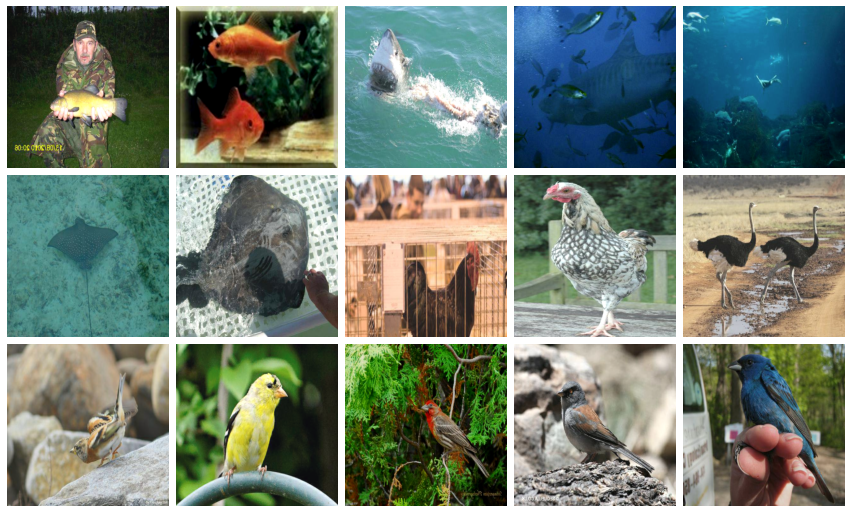

In [ ]:
backbone_infer_dataset_encode = get_backbone_inference_dataset(train_set_path, shuffle=True, augment=True)

num_cols = 3
num_rows = 5
backbone_infer_dataset_encode = backbone_infer_dataset_encode.unbatch().batch(num_cols * num_rows)
x, y = next(iter(backbone_infer_dataset_encode))
print(x["inp1"].shape)

fig = plt.figure(figsize=(15, 15))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for i, ax in enumerate(grid):
    ax.imshow(x["inp1"][i]/255)
    ax.axis("off")

del backbone_infer_dataset_encode

# Model

In [ ]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [ ]:
def get_scale_layer(rescale_mode = "tf"):
    # For keras_cv_attention_models module:
    # ref: https://github.com/leondgarse/keras_cv_attention_models/blob/main/keras_cv_attention_models/imagenet/data.py
    # ref function : init_mean_std_by_rescale_mode()

    # For effV2 (21k classes) : https://github.com/leondgarse/keras_efficientnet_v2

    if isinstance(rescale_mode, (list, tuple)):  # Specific mean and std
        mean, std = rescale_mode
    elif rescale_mode == "torch":
        mean = np.array([0.485, 0.456, 0.406]) * 255.0
        std = np.array([0.229, 0.224, 0.225]) * 255.0
    elif rescale_mode == "tf":  # [0, 255] -> [-1, 1]
        mean, std = 127.5, 127.5
    elif rescale_mode == "tf128":  # [0, 255] -> [-1, 1]
        mean, std = 128.0, 128.0
    elif rescale_mode == "raw01":
        mean, std = 0, 255.0  # [0, 255] -> [0, 1]
    else:
        mean, std = 0, 1  # raw inputs [0, 255]        
    scaling_layer = keras.layers.Lambda(lambda x: ( tf.cast(x, tf.float32) - mean) / std )
    
    return scaling_layer


def get_clip_model():
    inp = tf.keras.layers.Input(shape = [3, 336, 336]) # [B, C, H, W]
    backbone = TFCLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14-336",from_pt=True)
    output = backbone({'pixel_values':inp}).pooler_output
    return tf.keras.Model(inputs=[inp], outputs=[output])

def get_embedding_model():
    #------------------
    # Definition of placeholders
    inp = tf.keras.layers.Input(shape = [None, None, 3], name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')

    # Definition of layers
    layer_resize = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [config.IMAGE_SIZE, config.IMAGE_SIZE]), name='resize')
    layer_scaling = get_scale_layer(rescale_mode = "torch")
    layer_permute = tf.keras.layers.Permute((3,1,2))
    layer_backbone = get_clip_model()
    layer_dropout = tf.keras.layers.Dropout(0.2)
    layer_dense_before_arcface = tf.keras.layers.Dense(config.EMB_DIM)
    layer_margin = ArcMarginProduct(
        n_classes = config.N_CLASSES, 
        s = 30, 
        m = 0.3, 
        name=f'head/arcface', 
        dtype='float32'
        )
    layer_softmax = tf.keras.layers.Softmax(dtype='float32')
    layer_l2 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1), name='embedding_norm')
    
    if config.EMB_DIM != 64:
        layer_adaptive_pooling = tfa.layers.AdaptiveAveragePooling1D(64)
    else:
        layer_adaptive_pooling = tf.keras.layers.Lambda(lambda x: x )  # layer with no operation

    #------------------
    # Definition of entire model
    image = layer_scaling(inp)
    image = layer_resize(image)
    image = layer_permute(image)
    backbone_output = layer_backbone(image)
    embed = layer_dropout(backbone_output)
    embed = layer_dense_before_arcface(embed)
    x = layer_margin([embed, label])
    output = layer_softmax(x)
    model = tf.keras.models.Model(inputs = [inp, label], outputs = [output]) # whole architecture

    model.layers[-6].trainable = False
    opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
    model.compile(
        optimizer = opt,
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
        )

    #------------------
    # Definition of embedding model (for submission)
    embed_model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(None, None, 3), dtype='uint8'),
        layer_scaling,
        layer_resize,
        layer_permute,
        layer_backbone,
        layer_dropout,
        layer_dense_before_arcface,
        layer_adaptive_pooling,    # shape:[None, config.EMB_DIM] --> [None, 64]
        layer_l2,
    ])


    return model, embed_model

In [ ]:
with strategy.scope():
    model, emb_model = get_embedding_model()

if config.RESUME:
    print(f"load {config.RESUME_WEIGHT}")
    model.load_weights( config.RESUME_WEIGHT,skip_mismatch=True,by_name=True)
    #emb_model.load_weights( config.RESUME_WEIGHT )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCLIPVisionModel: ['text_model.encoder.layers.6.self_attn.out_proj.bias', 'text_model.encoder.layers.10.mlp.fc1.weight', 'text_model.encoder.layers.1.mlp.fc1.weight', 'text_model.encoder.layers.10.self_attn.k_proj.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.10.layer_norm1.weight', 'text_model.encoder.layers.1.layer_norm2.bias', 'text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.7.self_attn.out_proj.bias', 'text_model.encoder.layers.4.layer_norm1.bias', 'text_model.encoder.layers.1.mlp.fc2.weight', 'text_model.encoder.layers.6.self_attn.k_proj.weight', 'text_model.encoder.layers.7.self_attn.out_proj.weight', 'text_model.encoder.layers.3.layer_norm1.bias', 'text_model.encoder.layers.10.mlp.fc2.weight', 'text_model.encoder.layers.4.layer_norm2.bias', 'text_model.encoder.layers.10.layer_norm2.

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda (Lambda)                (None, None, None,   0           ['inp1[0][0]']                   
                                3)                                                                
                                                                                                  
 resize (Lambda)                (None, 336, 336, 3)  0           ['lambda[0][0]']                 
                                                                                            

In [ ]:
emb_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, None, 3)     0         
                                                                 
 resize (Lambda)             (None, 336, 336, 3)       0         
                                                                 
 permute (Permute)           (None, 3, 336, 336)       0         
                                                                 
 model (Functional)          (None, 1024)              303507456 
                                                                 
 dropout_24 (Dropout)        (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 adaptive_average_pooling1d   (None, 64)               0

# Scheduler

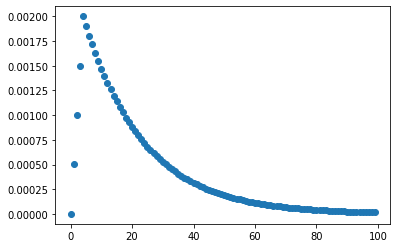

In [ ]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.95
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

# Train entire model 

In [ ]:
if config.TRAIN:
    sv_loss = tf.keras.callbacks.ModelCheckpoint(
        config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_loss.h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')

    steps_per_epoch = train_set_len // config.BATCH_SIZE  // 10     # "//10" means that the lr is update every 0.1 epoch.
    validation_steps = valid_set_len // config.BATCH_SIZE
    if valid_set_len % config.BATCH_SIZE != 0:
        validation_steps += 1
    print(steps_per_epoch, validation_steps)
    ds_train = get_backbone_inference_dataset(train_set_path, shuffle=True, augment=True, repeat=True)
    ds_valid = get_backbone_inference_dataset(valid_set_path, shuffle=False, augment=False, repeat=False)

    history = model.fit(
        ds_train,
        epochs=config.EPOCHS,
        callbacks=[get_lr_callback(), sv_loss],
        steps_per_epoch=steps_per_epoch,
        validation_data = ds_valid,
        validation_steps = validation_steps,
        verbose=1
    )

    # load best weight 
    model.load_weights( config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_entire.h5" )

In [ ]:
# save for debug
emb_model.save_weights( config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_emb_model.h5" )

# Create submission.zip

In [ ]:
save_locally = tf.saved_model.SaveOptions(
    experimental_io_device='/job:localhost'
)
emb_model.save('./embedding_norm_model', options=save_locally)

from zipfile import ZipFile

with ZipFile('submission.zip','w') as zip:           
    zip.write(
        './embedding_norm_model/saved_model.pb', 
        arcname='saved_model.pb'
    ) 
    zip.write(
        './embedding_norm_model/variables/variables.data-00000-of-00001', 
        arcname='variables/variables.data-00000-of-00001'
    ) 
    zip.write(
        './embedding_norm_model/variables/variables.index', 
        arcname='variables/variables.index'
    )